# The Principal Components of Anthropometry

In a previous post I explored the correlations between measurements in the ANSUR-II dataset, which includes 93 measurements from a sample of U.S. military personnel.
I found that measurements of the head were weakly correlated with measurements from other parts of the body -- and in particular the protrusion of the ears is almost entirely uncorrelated with anything else.

A friend of mine, and co-developer of the [Modeling and Simulation](https://greenteapress.com/wp/modsimpy/) class I taught at Olin, asked whether I had tried running principal component analysis (PCA).
I had not, but now I have. Let's look at the results.

This notebook is an offshoot of Chapter 1 of [*Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions*](https://probablyoverthinking.it).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/ansur_pca.ipynb).

In [1]:
# Install empirical dist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The data

Here's the ANSUR data, originally downloaded from [The OPEN Design Lab](https://www.openlab.psu.edu/ansur2/).

In [4]:
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/ANSURIIFEMALEPublic.csv")
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/ANSURIIMALEPublic.csv")

In [5]:
ansur_female = pd.read_csv("ANSURIIFEMALEPublic.csv", encoding="ISO-8859-1")
ansur_female.shape

(1986, 108)

In [6]:
ansur_male = pd.read_csv("ANSURIIMALEPublic.csv", encoding="ISO-8859-1")
ansur_male.shape

(4082, 108)

Since heights are in mm, I converted to cm.

In [7]:
height_male = ansur_male["stature"] / 10
height_female = ansur_female["stature"] / 10

In [8]:
measurements = [column for column in ansur_female.columns if column.lower() == column]
measurements

['abdominalextensiondepthsitting',
 'acromialheight',
 'acromionradialelength',
 'anklecircumference',
 'axillaheight',
 'balloffootcircumference',
 'balloffootlength',
 'biacromialbreadth',
 'bicepscircumferenceflexed',
 'bicristalbreadth',
 'bideltoidbreadth',
 'bimalleolarbreadth',
 'bitragionchinarc',
 'bitragionsubmandibulararc',
 'bizygomaticbreadth',
 'buttockcircumference',
 'buttockdepth',
 'buttockheight',
 'buttockkneelength',
 'buttockpopliteallength',
 'calfcircumference',
 'cervicaleheight',
 'chestbreadth',
 'chestcircumference',
 'chestdepth',
 'chestheight',
 'crotchheight',
 'crotchlengthomphalion',
 'crotchlengthposterioromphalion',
 'earbreadth',
 'earlength',
 'earprotrusion',
 'elbowrestheight',
 'eyeheightsitting',
 'footbreadthhorizontal',
 'footlength',
 'forearmcenterofgriplength',
 'forearmcircumferenceflexed',
 'forearmforearmbreadth',
 'forearmhandlength',
 'functionalleglength',
 'handbreadth',
 'handcircumference',
 'handlength',
 'headbreadth',
 'headcir

In [9]:
len(measurements)

93

In [10]:
ansur_male[measurements]

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight
0,266,1467,337,222,1347,253,202,401,369,274,...,1700,501,329,933,240,440,1054,815,175,853
1,233,1395,326,220,1293,245,193,394,338,257,...,1627,432,316,870,225,371,1054,726,167,815
2,287,1430,341,230,1327,256,196,427,408,261,...,1678,472,329,964,255,411,1041,929,180,831
3,234,1347,310,230,1239,262,199,401,359,262,...,1625,461,315,857,205,399,968,794,176,793
4,250,1585,372,247,1478,267,224,435,356,263,...,1679,467,303,868,214,379,1245,946,188,954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4077,235,1353,312,216,1263,228,193,384,318,241,...,1557,442,279,816,210,347,1016,675,163,778
4078,247,1473,336,234,1346,253,196,428,374,284,...,1715,475,351,978,235,385,1082,896,178,873
4079,264,1394,313,227,1280,245,193,407,367,271,...,1682,483,333,991,258,353,1011,832,178,822
4080,203,1417,327,223,1314,250,196,419,365,271,...,1589,430,293,783,192,350,1062,731,172,837


In [11]:
df = ansur_male[measurements]

## Principle Component Analysis

As you might guess from the comments below, I used ChatGPT to generate a lot of the code.
It took some revision to get it working, but the head start definitely saved me some time.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# In this example, we will first standardize the data and then perform PCA.

# Step 3.1: Create a StandardScaler step
scaler = StandardScaler()

# Step 3.2: Create a PCA step
pca = PCA(n_components=10) 

# Step 4: Create the pipeline
steps = [
    ('scaler', scaler),  # Standardize the data
    ('pca', pca)        # Perform PCA
]

pipeline = Pipeline(steps)

# Fit the pipeline to your data
pipeline.fit(df)

# Now, you can access the transformed data and principal components if needed.
transformed_data = pipeline.transform(df)  # Transformed data after PCA
principal_components = pca.components_    # Principal components (eigenvectors)

# You can also access the explained variance ratio to see how much variance is explained by each component.
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.44234507, 0.1749688 , 0.04206542, 0.03248167, 0.02284756,
       0.0211729 , 0.01887335, 0.01486428, 0.01423896, 0.0133352 ])

Here's a visualization of explained variance versus number of components.
I lifted this from [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

In [13]:
ys = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(len(ys)) + 1
ys

array([0.44234507, 0.61731386, 0.65937928, 0.69186095, 0.71470851,
       0.73588141, 0.75475477, 0.76961905, 0.78385801, 0.79719322])

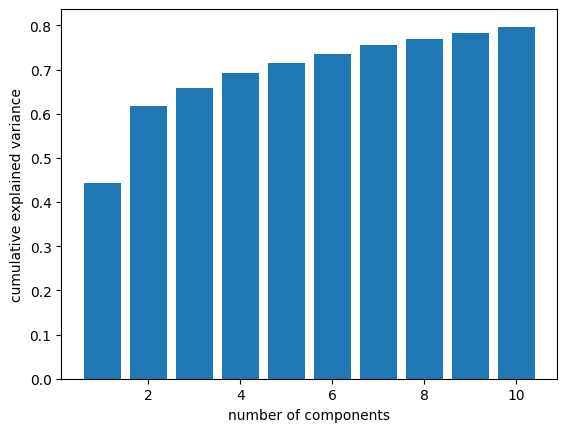

In [14]:
plt.bar(xs, ys)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.savefig('ansur_pca1.png', dpi=300)

With one component, we can capture 44% of the variation in the measurements.
With two components, we're up to 62%.
After that, the gains are smaller (as we expect), but with 10 measurements, we get up to 78%.

## Loadings

Looking at the loadings, we can see which measurements contribute the most to each of the components, so we can get a sense of which characteristics each component captures. 

In [15]:
loadings = pca.components_  # Get the loadings (eigenvectors)

# Create a DataFrame to store the loadings with feature names as columns
loadings_df = pd.DataFrame(loadings, columns=measurements)
loadings_df

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight
0,-0.085451,-0.134108,-0.116021,-0.100365,-0.127055,-0.105897,-0.112045,-0.108305,-0.092030,-0.103360,...,-0.124746,-0.094822,-0.097267,-0.095846,-0.087184,-0.082944,-0.114016,-0.131211,-0.115607,-0.120198
1,-0.162882,0.099494,0.106095,-0.092119,0.123047,-0.037801,0.064844,-0.017398,-0.141551,-0.055853,...,-0.096331,-0.038278,-0.157748,-0.165992,-0.161084,-0.061621,0.150431,-0.126668,-0.062109,0.048192
2,-0.014401,-0.122854,0.012456,0.022600,-0.112584,0.073201,0.118896,0.059992,0.103362,-0.135294,...,-0.167966,-0.179764,-0.081042,-0.045144,-0.021007,-0.228020,-0.030051,-0.003645,0.042591,-0.216036
3,0.173898,0.015042,0.085671,-0.166725,0.009383,-0.247039,-0.099253,-0.044553,0.032577,0.021470,...,-0.000860,0.023758,0.131947,0.161456,0.181414,-0.043152,0.010525,0.055897,-0.153359,-0.019571
4,0.066916,0.015896,-0.052721,0.179271,0.008850,0.149088,0.102492,-0.291511,0.025651,0.022473,...,0.014764,0.006342,0.053395,0.058110,0.067503,-0.048886,-0.011624,0.044010,0.064644,0.057507
5,0.068954,0.045088,0.008712,-0.079929,0.034763,-0.069300,-0.006755,-0.210778,-0.060386,0.027752,...,0.014994,0.083272,0.028884,0.050232,0.071746,0.007907,-0.017618,0.003730,-0.105865,0.075478
6,0.093950,0.012412,0.032486,-0.109475,-0.004806,0.024429,0.038766,-0.041518,-0.045085,0.026019,...,0.018555,0.283886,0.027571,0.070136,0.117156,0.203436,-0.123809,-0.022730,0.095440,0.009178
7,-0.049038,0.061742,-0.116182,-0.012438,0.048764,-0.002849,0.086757,-0.013694,0.095920,0.016898,...,-0.007324,0.042912,-0.065529,-0.050548,-0.026216,-0.137419,0.057734,0.006869,0.018921,0.200881
8,-0.000829,-0.041823,0.009860,0.127303,-0.038056,0.077260,0.145074,0.114277,-0.133338,0.249462,...,-0.064650,0.183266,0.107833,0.053013,0.021378,-0.059980,-0.048363,0.006234,-0.105640,-0.048509
9,0.081986,-0.014134,0.071271,-0.041166,-0.003983,-0.107577,0.029974,0.002414,-0.006934,-0.072455,...,0.053143,0.228368,0.020980,0.069906,0.092076,0.266613,-0.129199,0.027690,-0.009192,-0.089018


In [16]:
loadings_transposed = loadings_df.transpose()
loadings_transposed

,0,1,2,3,4,5,6,7,8,9
abdominalextensiondepthsitting,-0.085451,-0.162882,-0.014401,0.173898,0.066916,0.068954,0.093950,-0.049038,-0.000829,0.081986
acromialheight,-0.134108,0.099494,-0.122854,0.015042,0.015896,0.045088,0.012412,0.061742,-0.041823,-0.014134
acromionradialelength,-0.116021,0.106095,0.012456,0.085671,-0.052721,0.008712,0.032486,-0.116182,0.009860,0.071271
anklecircumference,-0.100365,-0.092119,0.022600,-0.166725,0.179271,-0.079929,-0.109475,-0.012438,0.127303,-0.041166
axillaheight,-0.127055,0.123047,-0.112584,0.009383,0.008850,0.034763,-0.004806,0.048764,-0.038056,-0.003983
...,...,...,...,...,...,...,...,...,...,...
waistfrontlengthsitting,-0.082944,-0.061621,-0.228020,-0.043152,-0.048886,0.007907,0.203436,-0.137419,-0.059980,0.266613
waistheightomphalion,-0.114016,0.150431,-0.030051,0.010525,-0.011624,-0.017618,-0.123809,0.057734,-0.048363,-0.129199
weightkg,-0.131211,-0.126668,-0.003645,0.055897,0.044010,0.003730,-0.022730,0.006869,0.006234,0.027690
wristcircumference,-0.115607,-0.062109,0.042591,-0.153359,0.064644,-0.105865,0.095440,0.018921,-0.105640,-0.009192


In [17]:
num_top_features = 5

# Iterate through each principal component
for i, col in loadings_transposed.items():
    print(f"Principal Component {i+1}:")
    
    # Sort the features by absolute loading values for the current principal component
    sorted_features = col.abs().sort_values(ascending=False)
    
    # Select the top N features with the highest absolute loadings
    top_features = sorted_features[:num_top_features]
    
    # Print the top correlated factors for the current principal component
    print(top_features)
    print()

Principal Component 1:
suprasternaleheight    0.135148
cervicaleheight        0.134192
buttockkneelength      0.134150
acromialheight         0.134108
kneeheightsitting      0.133213
Name: 0, dtype: float64

Principal Component 2:
waistcircumference                0.165992
poplitealheight                   0.163478
abdominalextensiondepthsitting    0.162882
waistdepth                        0.161084
buttockdepth                      0.158967
Name: 1, dtype: float64

Principal Component 3:
elbowrestheight            0.337938
eyeheightsitting           0.309937
sittingheight              0.306954
waistfrontlengthsitting    0.228020
heelbreadth                0.225393
Name: 2, dtype: float64

Principal Component 4:
balloffootcircumference    0.247039
bimalleolarbreadth         0.231812
footbreadthhorizontal      0.220147
handbreadth                0.218060
sittingheight              0.212324
Name: 3, dtype: float64

Principal Component 5:
interscyeii              0.319282
biacromialbreadt

I won't explain all of the measurements, but if there are any you are curious about, you can look them up in [*The Measurer’s Handbook*](http://tools.openlab.psu.edu/publicData/ANSURII-TR11-017.pdf) which includes details on "sampling strategy and measuring techniques" as well as descriptions and diagrams of the landmarks and measurements between them.

* Not surprisingly, the first component is loaded with measurements of height. If you want to predict someone's measurements, and can only use one number, choose height.

* The second component is loaded with measurements of girth. Again, no surprises so far.

* The third component seems to capture torso length. And that makes sense, too. One you know how tall someone is, it helps to know how that height is split between torso and legs.

* The fourth component seems to capture hand and foot size (with sitting height thrown in just to remind us that PCA is not obligated to find components that align perfectly with the axes we expect).

* Component 5 is all about the shoulders.

* Component 6 is all about the head.

After that, things are not so neat. But two things are worth noting:

* Component 7 is mostly related to the dimensions of the pelvis, but...

* Components 7, 8, and 10 are surprisingly loaded up with ear measurements.

As we saw in the previous article, there seems to be something special about ears.
Once you have exhausted the information carried by the most obvious measurements, the dimensions of the ear seem to be strangely salient.

## Using the pca module

I found [this module](https://erdogant.github.io/pca/pages/html/index.html) and decided to experiment with it.

In [18]:
try:
    from pca import pca
except ImportError:
    !pip install pca
    from pca import pca

In [19]:
model = pca(normalize=True, n_components=10)
model.fit_transform(df);

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [93] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


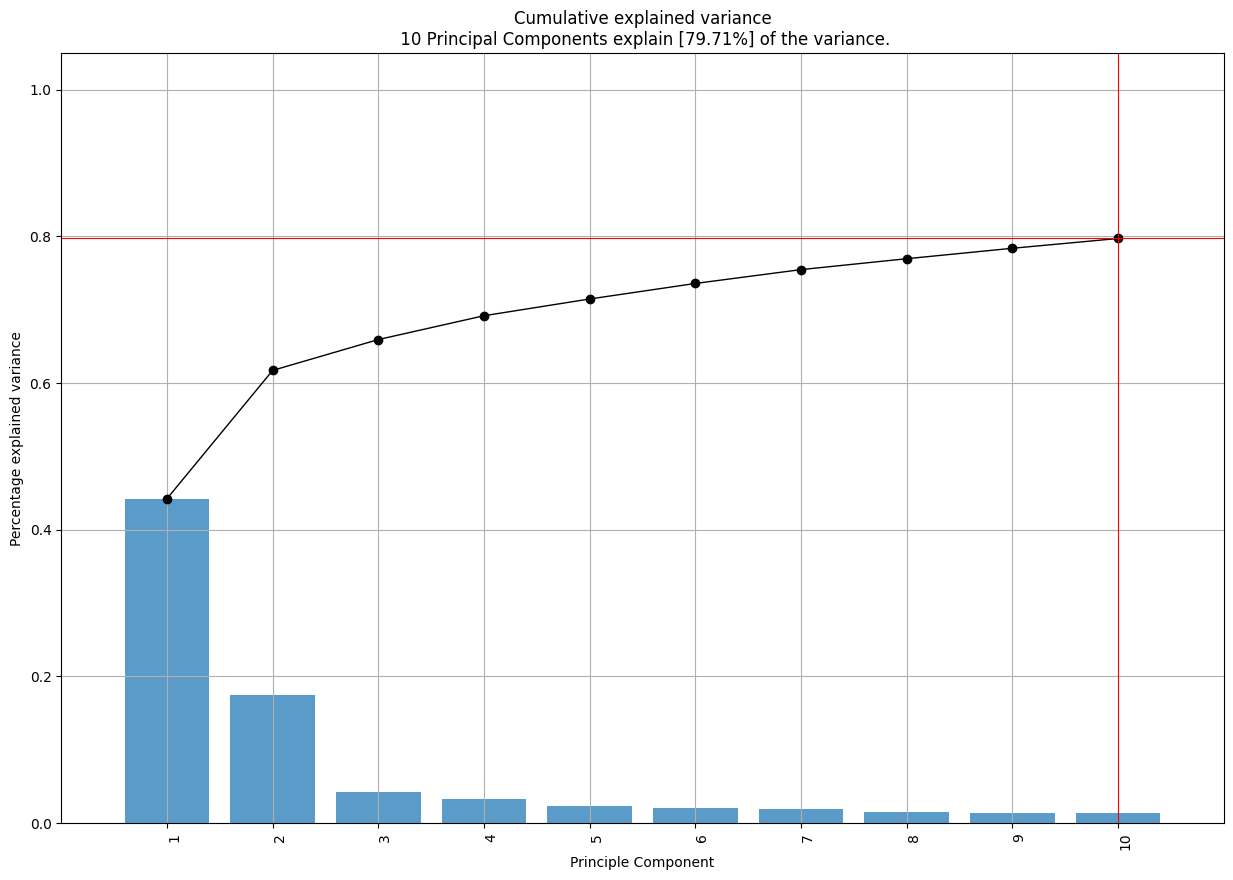

In [20]:
model.plot();

Unfortunately, the most interesting plots don't seem to work well with the number of dimensions in this dataset.
I'd be curious to know if they can be tuned to work better.

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


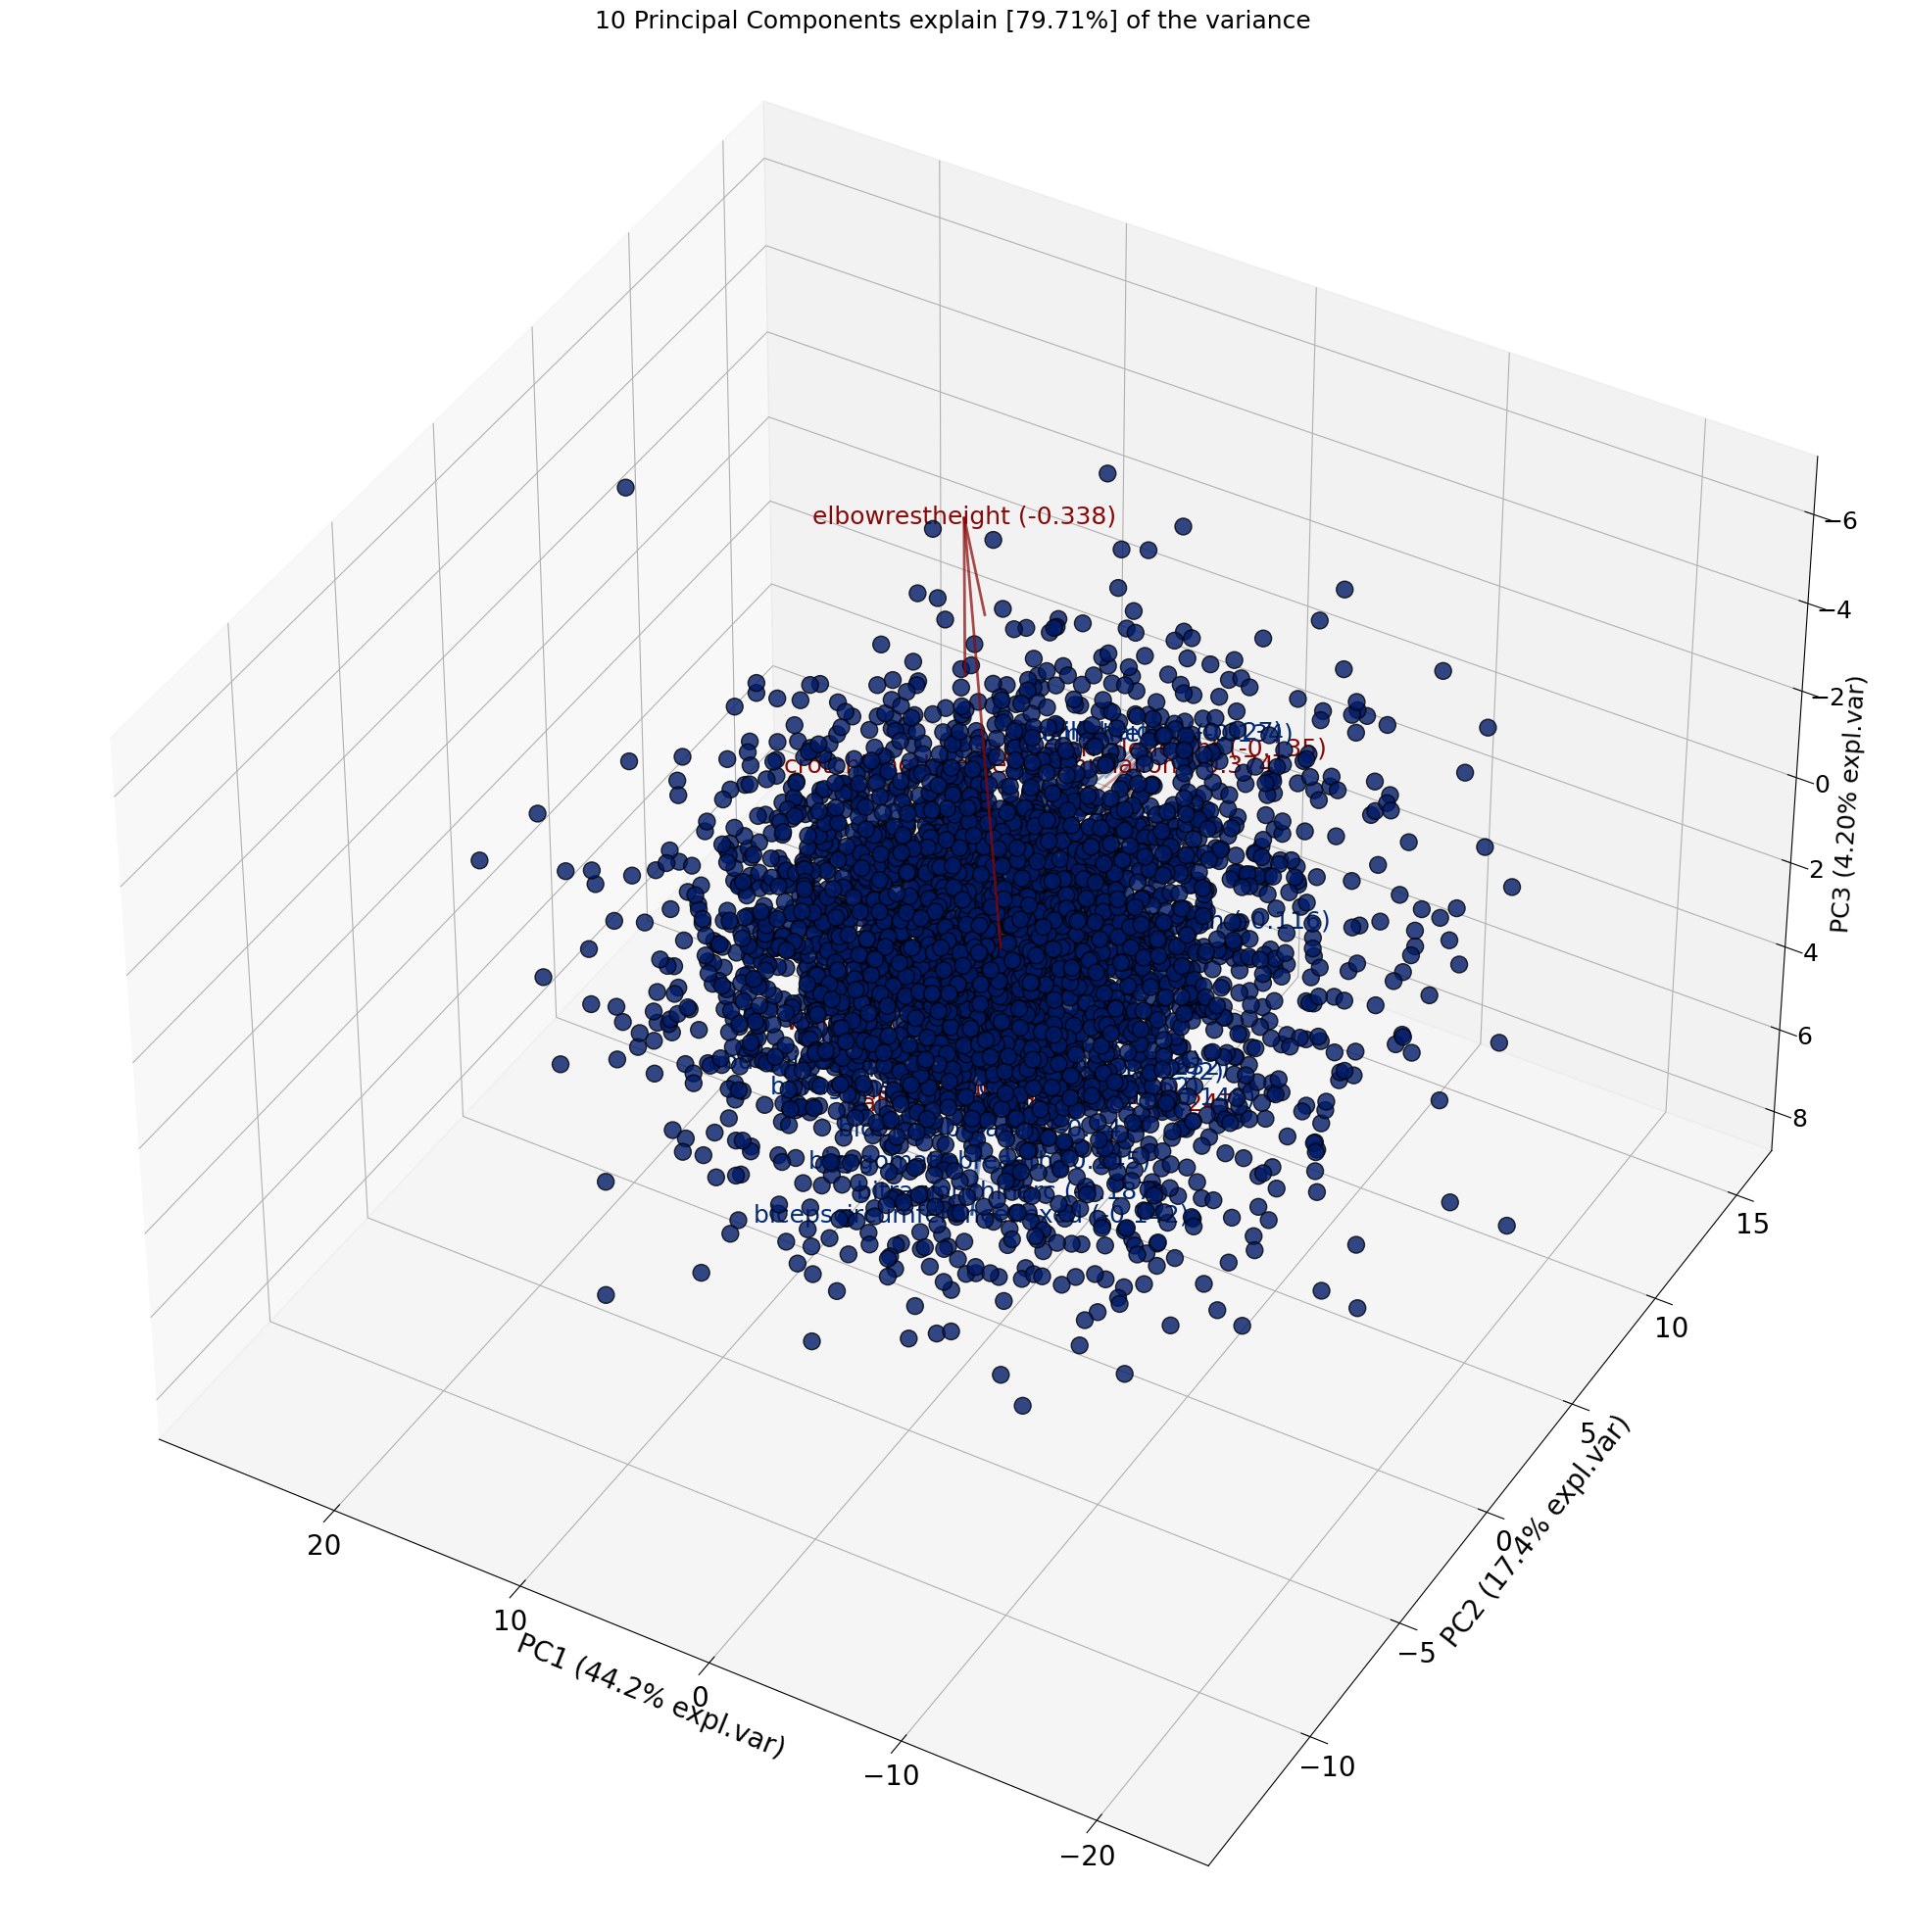

In [21]:
model.biplot3d();

Copyright 2023 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).